<a href="https://colab.research.google.com/github/Yash-Shindey/Glaucoma-Detection/blob/main/Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataScience Capstone Project
## Authors :
#### - Yash Shindey ENG21CS0484
#### - Spandan Das ENG21CS0520
## Notes:
_The project is done in virtual environment using anaconda navigator so install the require packages. Try to use 3.9 since most compatible. keras is now part of tensorflow_

This code cell imports the `sys` module to access Python interpreter's functionalities:

- `sys.executable`: Displays the path to the Python executable being used, useful for verifying the active Python environment.
- `sys.version`: Outputs the currently running Python version, helping to confirm compatibility with libraries or applications.

In [ ]:
import sys
print(sys.executable)
print(sys.version)

/opt/anaconda3/envs/tf_env/bin/python
3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]


### Cell 1: Import necessary libraries and display metadata

This cell performs the following tasks:

- **Suppress Warnings**: Import `warnings` and use `filterwarnings("ignore")` to prevent the display of warning messages, making output cleaner.
- **Import Libraries**: Load necessary libraries for data handling (`numpy`, `pandas`), file management (`os`, `glob`, `pathlib`), image processing (`PIL.Image`, `cv2`), and visualization (`matplotlib.pyplot`).
- **Clustering Tool**: Import `KMeans` from `sklearn.cluster` for potential clustering tasks.
- **Load and Display Data**:
  - `meta = pd.read_csv("glaucoma.csv")`: Reads a CSV file containing metadata about the dataset, presumably related to glaucoma studies.
  - `print(meta.head())`: Displays the first few entries of the dataset to provide a quick look at the data structure.
  - `print(meta["Glaucoma"].value_counts())`: Outputs the distribution of data classes, showing the count of samples with and without glaucoma.

In [ ]:
# Cell 1: Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

# Read and display the metadata
meta = pd.read_csv("glaucoma.csv")
print(meta.head())
print(meta["Glaucoma"].value_counts())

  Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0
3  004.jpg  0.7246  OD   A         0
4  005.jpg  0.6138  OS   A         0
Glaucoma
0    482
1    168
Name: count, dtype: int64


### Cell 2: Define paths and read images

This cell handles image path setup and integration with metadata:

- **Define Paths**: Collects all JPEG images from the directory `"ORIGA/ORIGA/Images/"` using `glob`, which helps in fetching the filenames in a specified pattern.
- **Root Directory**: Sets a root path for the images to simplify path management.
- **Create Full Path**:
  - Updates the `meta` DataFrame by adding a new column `Path`. This column is created by appending each filename from the `Filename` column of `meta` to the `root` path, ensuring each entry has a complete file path.
  - This is achieved using the `apply` function with a lambda that joins `root` with filenames using `os.path.join`.
- **Display Updated Data**: Prints the head of the DataFrame to show the first few entries, now including the full image paths.


In [ ]:
# Cell 2: Define paths and read images
all_images = glob("ORIGA/ORIGA/Images/*.jpg")
root = "ORIGA/ORIGA/Images/"

# Join the root path with the filename to create a full path
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(root, fn))
print(meta.head())


  Filename  ExpCDR Eye Set  Glaucoma                        Path
0  001.jpg  0.7097  OD   A         0  ORIGA/ORIGA/Images/001.jpg
1  002.jpg  0.6953  OS   A         0  ORIGA/ORIGA/Images/002.jpg
2  003.jpg  0.9629  OS   A         0  ORIGA/ORIGA/Images/003.jpg
3  004.jpg  0.7246  OD   A         0  ORIGA/ORIGA/Images/004.jpg
4  005.jpg  0.6138  OS   A         0  ORIGA/ORIGA/Images/005.jpg


### Cell 3: Calculate mean of ExpCDR and display an example image

This cell focuses on statistical analysis and image visualization:

- **Statistical Analysis**:
  - Calculates and prints the mean of the `ExpCDR` values grouped by the `Glaucoma` status using `groupby` and `mean()`. This helps in understanding the average Cup to Disc Ratio (CDR) among groups with and without glaucoma.
- **Image Visualization**:
  - Loads the first image from the `all_images` list using `PIL.Image.open`.
  - Prints the size of the loaded image to understand its dimensions.
  - Displays the image using `matplotlib.pyplot`. This visual check can be useful for verifying the integrity and appropriateness of the image data for further analysis.

Glaucoma
0    0.542243
1    0.674040
Name: ExpCDR, dtype: float64
(3072, 2048)


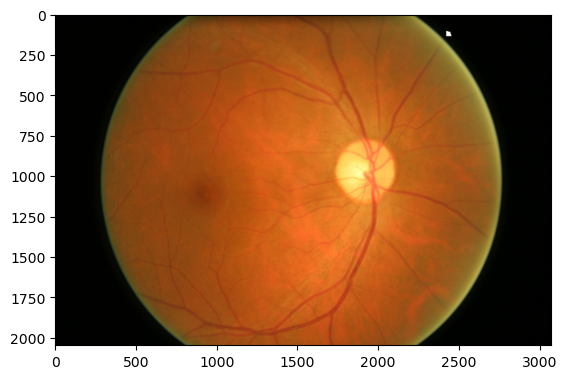

In [ ]:
# Cell 3: Calculate and print the mean of ExpCDR for Glaucoma groups
print(meta.groupby("Glaucoma")["ExpCDR"].mean())

# Load and display an example image
image = Image.open(all_images[0])
print(image.size)
plt.imshow(image)
plt.show()


### Cell 4: Define image processing functions

This cell includes the definition of multiple functions used for enhancing and manipulating images:

- **Gamma Correction**:
  - `gamma_correct`: Adjusts the gamma of an image, enhancing brightness and contrast. Uses a look-up table for efficiency.

- **Contrast Limited Adaptive Histogram Equalization (CLAHE)**:
  - `clahe`: Applies CLAHE to a grayscale image, improving local contrast.
  - `clahe_rgb`: Extends `clahe` to RGB images by applying the function separately to each channel and merging them back.

- **Gaussian Blur**:
  - `apply_gaussian`: Applies Gaussian blur to smooth the image, reducing noise and detail.

- **Bounding Box Calculation**:
  - `get_bounding_box`: Finds the largest contour in a binary mask and returns its bounding box.

- **Black Padding Removal**:
  - `remove_black_padding`: Removes black padding from an image based on a threshold, processes the image through various enhancement techniques, and crops/resizes the result for consistency.

These functions are essential for pre-processing images for further analysis or machine learning tasks, ensuring that the images are optimized for the best possible outcomes.


In [ ]:
# Cell 4: Define image processing functions
def gamma_correct(img, gamma=0.4):
    img = img.astype(np.uint8)
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    out = cv2.LUT(img, lookUpTable)
    return out

def clahe(image, cl=2.0, tgs=8):
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(tgs, tgs))
    return clahe.apply(image)

def clahe_rgb(img, cl=2.0, tgs=8):
    g, b, r = cv2.split(img)
    return cv2.merge([clahe(channel, cl, tgs) for channel in [g, b, r]])

def apply_gaussian(img):
    return cv2.GaussianBlur(img, (5,5), 0)

def get_bounding_box(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return [x, y, w, h]

def remove_black_padding(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    x, y, w, h = get_bounding_box(th)
    c_size = 300
    final_size = 224
    images = []
    for i, image in enumerate([clahe(gray), gamma_correct(gray, 3), clahe_rgb(img), img]):
        crop = image[y+c_size:y+h-c_size, x+c_size:x+w-c_size]
        crop_resized = cv2.resize(crop, (final_size, final_size))
        if i == 2:
            images.append(crop)
        images.append(crop_resized)
    return images


### Cell 5: Define more image processing functions

This cell introduces further specialized functions for image processing tasks:

- **Crop Cup and Disc**:
  - `crop_cup_disc`: Extracts the region around the optical cup and disc from retinal images. It first calculates the bounding box from a mask, adjusts it according to the actual image dimensions, and then crops the image around the center of this box. The result is resized to a predefined size, making it suitable for further analysis or machine learning applications.

- **Ensure Cluster Groups**:
  - `ensure_cluster_groups`: Reorders clustering labels based on the mean intensities within each cluster. This function is useful for consistent labeling across multiple datasets or images, ensuring that cluster labels correspond to similar features (like brightness or color intensity) across different images.

These functions enhance the ability to preprocess and standardize features in image datasets, particularly useful in tasks such as image classification or segmentation.


In [ ]:
# Cell 5: Define more image processing functions
def crop_cup_disc(img, mask):
    x, y, w, h = get_bounding_box(mask)
    width_ratio = img.shape[1]/mask.shape[1]
    height_ratio = img.shape[0]/mask.shape[0]
    x, w = int(x * width_ratio), int(w * width_ratio)
    y, h = int(y * height_ratio), int(h * height_ratio)
    cx, cy = x + w//2, y + h//2
    c_size = 300
    x_start = (cx - c_size) if (cx > c_size) else 0
    y_start = (cy - c_size) if (cy > c_size) else 0
    crop = img[y_start:cy + c_size, x_start:cx + c_size]
    final_size = 224
    return cv2.resize(crop, (final_size, final_size))

def ensure_cluster_groups(data_2d, labels, clusters=4):
    mean_intensities = [data_2d[labels == i].mean() for i in range(clusters)]
    label_map = {i: label for i, label in sorted(enumerate(mean_intensities), key=lambda pair: pair[1])}
    label_map = {k: i for i, k in enumerate(label_map.keys())}
    mapped_labels = np.vectorize(label_map.get)(labels)
    return mapped_labels


### Cell 6: Define image segmentation and morphology functions

This cell includes functions designed for advanced image processing, focusing on segmentation and morphology:

- **Cluster Image**:
  - `cluster_image`: Converts an image into a 2D array for processing with KMeans clustering, used here to segment the image into multiple clusters based on pixel intensity. The labels from clustering are re-ordered for consistency using the `ensure_cluster_groups` function, then reshaped to match the original image. Finally, a binary mask is created to highlight specific clusters, typically those with higher intensity, which are useful for isolating significant features in images.

- **Apply Morphology**:
  - `apply_morphology`: Enhances the binary mask by applying morphological operations. It starts with an "opening" operation to remove small noise points, followed by a "closing" operation to fill in small holes within the objects in the foreground. This process uses a defined kernel to ensure the operations are applied uniformly.

These functions are crucial for preparing images for detailed analysis, helping to enhance and isolate important features while reducing noise and imperfections.


In [ ]:
# Cell 6: Define image segmentation and morphology functions
def cluster_image(img, n_clusters=6):
    # Convert image to 2D array
    data_2d = img.reshape(-1, 1)
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=3, random_state=0).fit(data_2d)
    # Reshape the labels back to original shape
    labels = kmeans.labels_
    labels = ensure_cluster_groups(data_2d, labels, n_clusters)
    labels = labels.reshape(img.shape)
    # Create a binary mask by thresholding the cluster with highest intensity values
    mask = np.isin(labels, [4, 5])
    mask = (mask * 255).astype(np.uint8)
    return mask

def apply_morphology(binary_mask):
    # Define a kernel for morphological operations
    kernel = np.ones((5,5),np.uint8)
    # Apply opening to remove small noise
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations = 1)
    # Apply closing to close small holes inside the foreground objects
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)
    return closing


### Cell 7: Visualize the processed images

This cell showcases the output of various image processing steps on a subset of the dataset:

- **Setup Plot**: Initializes a figure with subplots arranged in a 5x4 grid to display different processing stages for four images.
- **Image Processing and Display**:
  - **Loop through Images**: Iterates over four specific images, performing the following steps for each:
    - **Metadata Extraction**: Retrieves diagnosis (Glaucoma or not) and the Expected Cup to Disc Ratio (ExpCDR) from the metadata.
    - **Image Reading and Processing**: Applies previously defined functions (`remove_black_padding`, `cluster_image`, `apply_morphology`, `crop_cup_disc`) to enhance and segment the images.
  - **Visualization**:
    - Displays the original cropped RGB image, CLAHE enhanced cropped RGB image, CLAHE enhanced grayscale image, segmented image of the disc, and the final cropped image of the cup in RGB after all enhancements and segmentations.
    - Each subplot is labeled with the Glaucoma status and ExpCDR to contextualize the visual output.
- **Display Setup**: Adjusts layout for better spacing and shows the figure with all subplots.

This visualization aids in assessing the effectiveness of image processing steps and provides a visual comparison between original and processed images, highlighting key areas like the optical disc and cup.


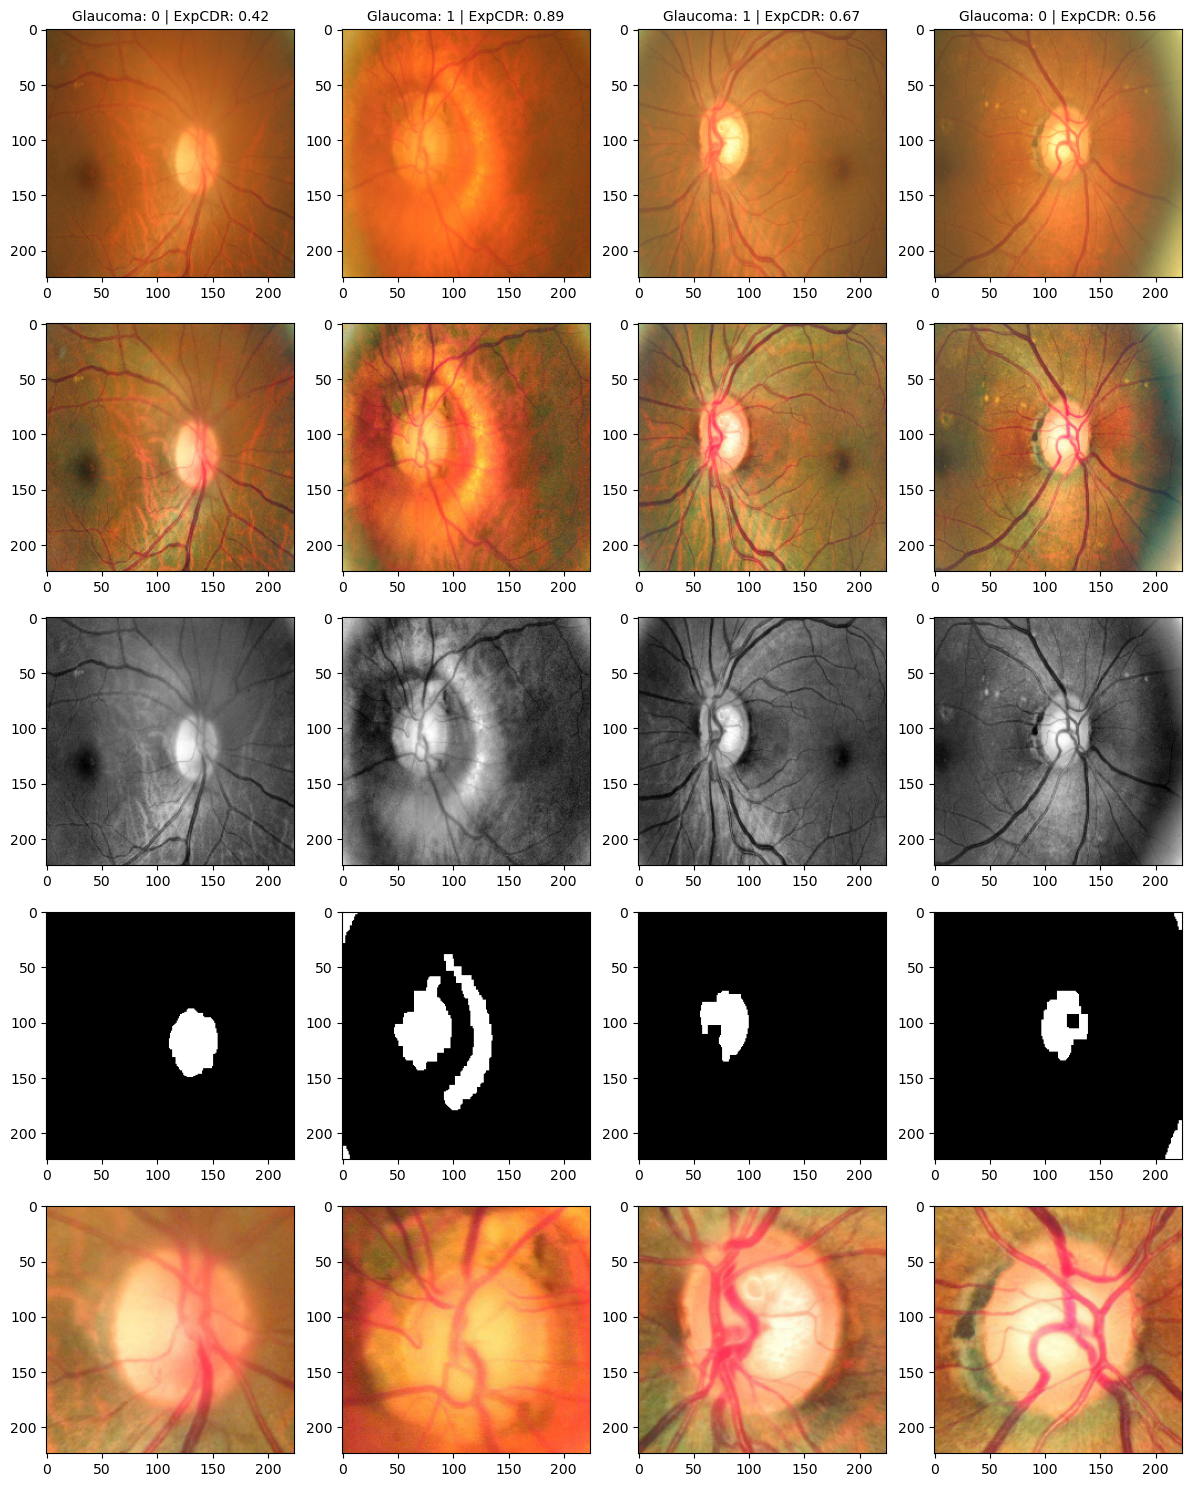

In [ ]:
# Cell 7: Visualize the processed images
fig, axs = plt.subplots(5, 4, figsize=(12, 15))

for i in range(4):
    path = all_images[160 + i]

    # Finding Glaucoma Dx and ExpCDR
    file_name = Path(path).parts[-1]
    row = meta.loc[meta["Filename"] == file_name].iloc[0]
    gl, exp_cdr = row["Glaucoma"], row["ExpCDR"]

    img = cv2.imread(path)
    clahe_gray, corrected_gray, rgb_clahe_org, rgb_clahe_cropped, rgb_cropped = remove_black_padding(img, 10)

    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)

    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)

    axs[0, i].imshow(rgb_cropped[..., ::-1])
    axs[0, i].set_title(f"Glaucoma: {gl} | ExpCDR: {exp_cdr:0.2f}", fontsize=10)
    axs[1, i].imshow(rgb_clahe_cropped[..., ::-1])
    axs[2, i].imshow(clahe_gray, cmap='gray')
    axs[3, i].imshow(segmented, cmap='gray')
    axs[4, i].imshow(rgb_cup[..., ::-1])

plt.tight_layout()
plt.show()

### Cell 8: Save processed images and prepare data splits for training

This cell is dedicated to finalizing pre-processing and setting up data for model training:

- **Prepare Save Directory**:
  - Checks if a directory exists for saving cropped images. If not, it creates one.

- **Process and Save Images**:
  - Iterates over all image paths using `tqdm` to visually track progress.
  - For each image, it performs the following steps:
    - Reads the image and applies `remove_black_padding` and `cluster_image` to process it.
    - Applies `apply_morphology` for refining segmentation.
    - Crops the region of interest using `crop_cup_disc`.
    - Saves the processed image to the specified directory.

- **Prepare Data for Model Training**:
  - Filters metadata to separate samples with and without glaucoma.
  - Combines a subset of both groups into a new DataFrame to balance the dataset.
  - Splits the dataset into training and testing subsets using `train_test_split` from `sklearn.model_selection`, allocating 25% of data for testing.
  - Prints the shapes of the training and testing datasets to confirm their sizes.

This step is crucial for preparing the image data in a form suitable for training machine learning models, ensuring that the data is well-organized and accessible.


In [ ]:
# Cell 8: Save processed images and prepare data splits for training
from tqdm.notebook import tqdm

# Define a directory to save the cropped images
save_path = "./cropped_images"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Process each image, segment, and save the results
for image_path in tqdm(all_images):
    image_name = Path(image_path).name
    new_path = os.path.join(save_path, image_name)
    img = cv2.imread(image_path)
    _, corrected_gray, rgb_clahe_org, _, _ = remove_black_padding(img, 10)

    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)

    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)

    cv2.imwrite(new_path, rgb_cup)

# Split the dataset for training and testing
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)


  0%|          | 0/650 [00:00<?, ?it/s]

(253, 6) (85, 6)


### Cell 9: Setup PyTorch dataset and data loaders

This cell sets up the data handling for a PyTorch-based deep learning model:

- **Import Necessary Modules**:
  - `torch`, `Dataset`, and `DataLoader` from `torch.utils.data` for data handling in PyTorch.
  - `transforms` from `torchvision` for image preprocessing.
  - `Image` from `PIL` for image loading and processing.

- **Define Custom Dataset Class**:
  - `GlaucomaDataset`: A custom dataset class inheriting from `Dataset`. It initializes with a DataFrame, optional transformations, and constructs a dataset by iterating over the DataFrame to extract image paths, labels, and additional metadata like `ExpCDR`.
  - `__getitem__`: Loads and transforms images as needed, returning the processed image, metadata, and label as a tuple.

- **Define Transformations**:
  - Different transformations for training and testing datasets to augment and normalize images, respectively, enhancing model generalization and standardizing input.

- **Initialize Datasets and Loaders**:
  - `train_data` and `test_data` are instantiated using the custom dataset class with respective transformations.
  - `train_loader` and `test_loader` are set up with defined batch sizes and shuffle configurations to facilitate efficient and randomized access during model training and evaluation.

- **Optional Visualization**:
  - Visualizes a batch of processed images to verify data loader functionality and transformations effectiveness. This step is crucial for ensuring that the images are correctly processed and ready for input into the model.

This setup is essential for preparing the dataset for efficient training using PyTorch, leveraging transformations and custom loading mechanisms to handle complex data structures and training procedures.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


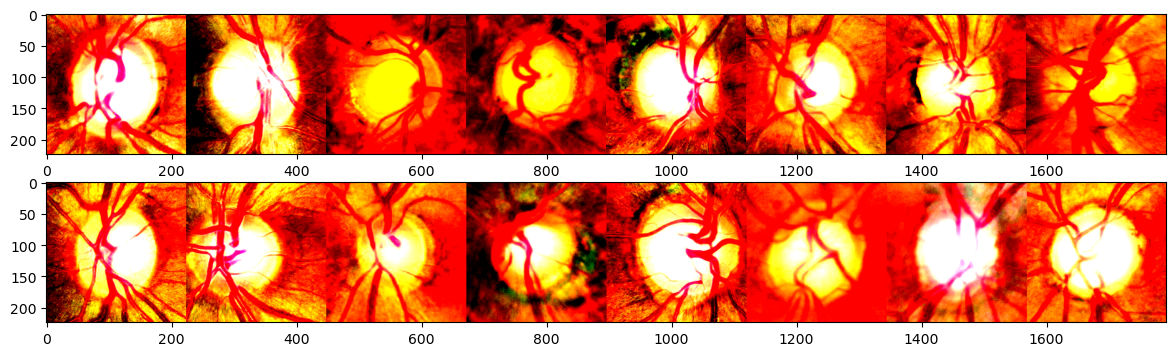

In [ ]:
# Cell 9: Setup PyTorch dataset and data loaders
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define a custom dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.data = self.get_data()

    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            name = Path(row["Path"]).parts[-1]
            path = os.path.join(save_path, name)
            data.append(((path, exp_cdr), label))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.229])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.229])
])

# Create dataset objects
train_data = GlaucomaDataset(train_df, transform=train_transforms)
test_data = GlaucomaDataset(test_df, transform=test_transforms)

# Initialize data loaders
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

# Optional: Visualize one batch of images
one_batch = next(iter(train_loader))
batch_imgs = one_batch[0][0].numpy()
rows = 2
fig, axs = plt.subplots(rows, 1, figsize=(16, 4))
for i in range(rows):
    img = np.hstack([batch_imgs[j].transpose(1, 2, 0) for j in range(i * (b_size//rows), (b_size//rows) * (i+1))])
    axs[i].imshow(img)
plt.show()


### Cell 10: Define the neural network architecture and training setup

This cell sets up the architecture for a neural network model and its training procedure:

- **Import Required Modules**:
  - `torch`, `nn`, `optim` for defining and optimizing neural networks.
  - `transforms`, `resnet50` from `torchvision` for image transformations and using pretrained models.
  - `Dataset`, `DataLoader`, `Image` for data handling and loading.
  - `Path` and `os` for file operations.

- **Custom Dataset Class**:
  - `GlaucomaDataset`: Manages loading and transforming images for training and testing, associating each with its label from the DataFrame.

- **Transformations**:
  - Defines transformations for resizing, converting to tensor, and normalizing images to prepare them for input into the network.

- **Data Loaders**:
  - Initializes data loaders for both training and testing datasets with specified batch sizes and shuffle configurations.

- **Network Architecture (`GlaucomaNet`)**:
  - Inherits from `nn.Module`.
  - Utilizes a pretrained `resnet50` model, replacing the final fully connected layer to suit the binary classification task (glaucoma detection).
  - Forward pass definition to handle input through the network.

- **Model Initialization and Setup**:
  - Instantiates the model and sets it to run on GPU if available.
  - Defines a binary cross-entropy loss function for binary classification and an Adam optimizer for learning.

- **Training Loop**:
  - Defines a function `train_model` that runs training and evaluation, printing out loss statistics for each epoch.
  - Supports toggling between training and evaluation modes.

- **Execution**:
  - Commences the training process using the defined model, dataloaders, loss function, optimizer, and number of epochs.

This comprehensive setup prepares the neural network for learning to detect glaucoma from the processed image data, leveraging both the power of pretrained models and custom training routines.


In [ ]:
# Cell 10: Define the neural network architecture and training setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import os

# Dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.data = [(os.path.join("./cropped_images", row["Filename"]), row["Glaucoma"]) for _, row in df.iterrows()]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32).unsqueeze(0)

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.229])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.229])
])

# Loading data
train_dataset = GlaucomaDataset(train_df, transform=train_transforms)
test_dataset = GlaucomaDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the network architecture
class GlaucomaNet(nn.Module):
    def __init__(self, num_classes=1):
        super(GlaucomaNet, self).__init__()
        self.resnet = resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = GlaucomaNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

# Setup dataloaders dictionary
dataloaders = {'train': train_loader, 'test': test_loader}

# Start training
train_model(model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------
train Loss: 0.7311
test Loss: 1.5895
Epoch 2/10
----------
train Loss: 0.5166
test Loss: 1.6536
Epoch 3/10
----------
train Loss: 0.4871
test Loss: 1.2334
Epoch 4/10
----------
train Loss: 0.4415
test Loss: 0.5864
Epoch 5/10
----------
train Loss: 0.2583
test Loss: 0.8571
Epoch 6/10
----------
train Loss: 0.1820
test Loss: 3.0919
Epoch 7/10
----------
train Loss: 0.3319
test Loss: 2.0934
Epoch 8/10
----------
train Loss: 0.4172
test Loss: 3.1960
Epoch 9/10
----------
train Loss: 0.3626
test Loss: 1.1373
Epoch 10/10
----------
train Loss: 0.2200
test Loss: 1.6538


### Cell 11: Evaluate the model and visualize the results

This cell focuses on evaluating the performance of the trained model and visualizing some prediction results:

- **Import Libraries**:
  - `matplotlib.pyplot` and `numpy` for plotting and numerical operations.

- **Evaluation and Visualization Function**:
  - `evaluate_and_visualize`: Defines a function to evaluate the model using a given dataloader. The function sets the model to evaluation mode, computes predictions, and calculates accuracy by comparing predictions to true labels.
  - **Accuracy Calculation**: Calculates the accuracy as the percentage of correctly predicted cases.
  - **Visualization**:
    - Visualizes a subset of images from the last batch processed along with their predicted and actual labels. This helps in assessing the model's performance visually.
    - Images are un-normalized before displaying to convert them back to their original color format.
    - Displays up to 10 images in a grid layout, showing the prediction versus the actual label.

- **Execute Function**:
  - Calls `evaluate_and_visualize` to run the evaluation on the test dataset and display results.

This setup is crucial for testing the effectiveness of the neural network in real scenarios and providing visual feedback on its performance. Visualizing the predictions alongside the actual data helps in understanding the model's practical capabilities and areas that might need improvement.


Accuracy of the model on the test images: 67.05882352941177%


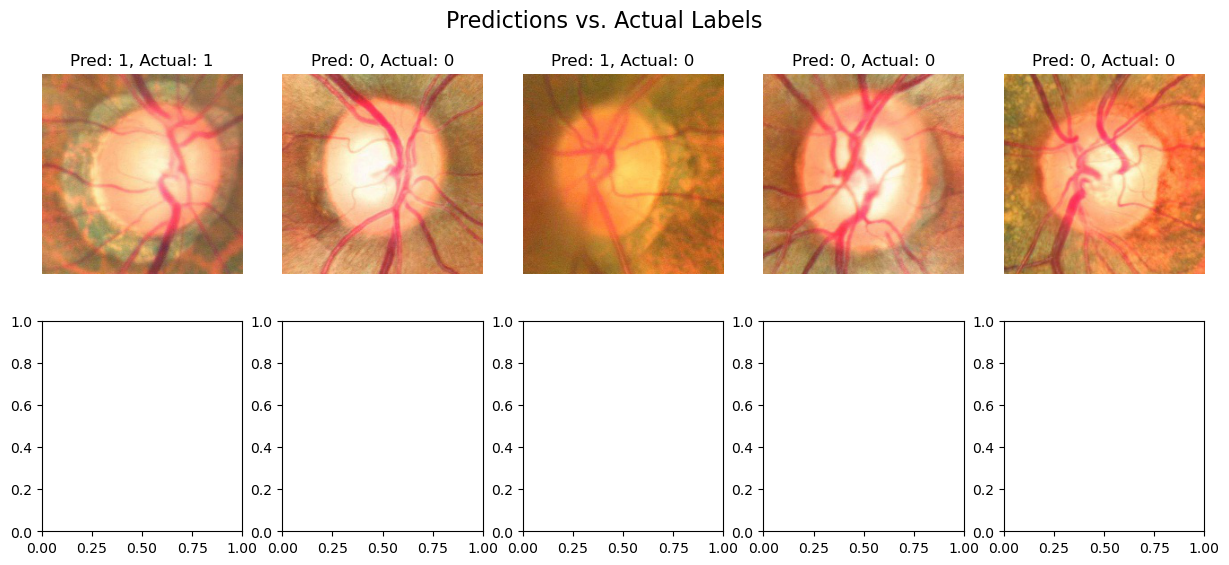

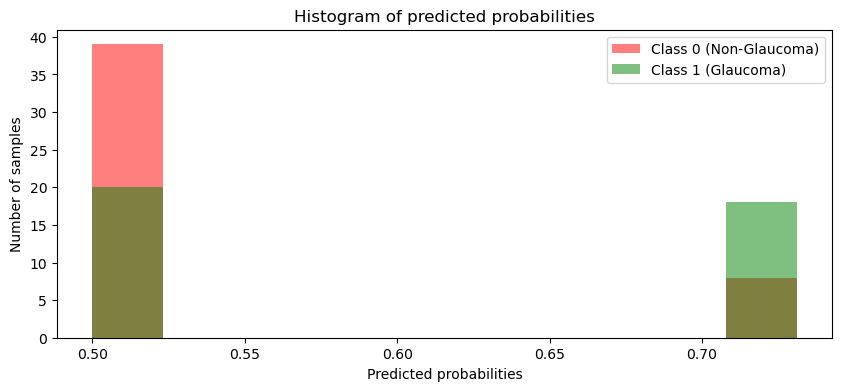

In [ ]:
# Cell 11: Evaluate the model and visualize the results
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to evaluate the model and visualize some predictions
def evaluate_and_visualize(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.sigmoid(outputs).round()  # Using sigmoid and rounding to get binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')

    # Visualization of predictions and actual labels
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Predictions vs. Actual Labels', fontsize=16)
    for i, (image, label, pred) in enumerate(zip(images.cpu().data.numpy(), labels.cpu().numpy(), predicted.cpu().numpy())):
        if i < 5:  # Display only the first 5 images
            ax = axs[i // 5, i % 5]
            img = image.transpose(1, 2, 0)
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Pred: {int(pred[0])}, Actual: {int(label[0])}')

    # Flatten all_labels and all_preds for consistency
    all_labels_np = np.array(all_labels).flatten()
    all_preds_probs = torch.sigmoid(torch.tensor(all_preds)).numpy().flatten()

    # Now the shapes should match and both should be 1D
    assert all_labels_np.ndim == 1, "all_labels_np is not 1D"
    assert all_preds_probs.ndim == 1, "all_preds_probs is not 1D"
    assert all_labels_np.shape[0] == all_preds_probs.shape[0], "Shapes do not match"

    # Visualization of prediction probabilities
    plt.figure(figsize=(10, 4))
    plt.hist(all_preds_probs[all_labels_np == 0], bins=10, alpha=0.5, label='Class 0 (Non-Glaucoma)', color='red')
    plt.hist(all_preds_probs[all_labels_np == 1], bins=10, alpha=0.5, label='Class 1 (Glaucoma)', color='green')
    plt.xlabel('Predicted probabilities')
    plt.ylabel('Number of samples')
    plt.title('Histogram of predicted probabilities')
    plt.legend()
    plt.show()

# Assuming 'test_loader' and 'device' are defined
evaluate_and_visualize(model, test_loader, device)


### Cell 12: Confusion Matrix and ROC Curve Analysis

This cell provides detailed statistical analysis of the model's performance through confusion matrices and ROC curve analysis:

- **Import Necessary Libraries**:
  - Utilizes `itertools`, `torch`, and modules from `sklearn.metrics` and `matplotlib.pyplot` for calculations and visualizations.

- **Define Confusion Matrix Plotting Function**:
  - `plot_confusion_matrix`: A utility function to plot the confusion matrix, either normalized or not, to visualize the accuracy of predictions against true labels. The function includes options for customization such as color map and title.

- **Extract Predictions and True Labels**:
  - Runs the model in evaluation mode to collect all predictions and corresponding true labels from the test set. Predictions are thresholded to binary values using a sigmoid function.

- **Compute and Plot Confusion Matrix**:
  - Calculates both a normalized and a non-normalized confusion matrix to compare the frequency of each class's predictions against their actual values.
  - Displays these matrices with annotations that indicate the count or proportion of predictions for each class.

- **ROC Curve and AUC Calculation**:
  - Computes the Receiver Operating Characteristic (ROC) curve, which illustrates the diagnostic ability of the classifier by plotting the true positive rate against the false positive rate at various threshold settings.
  - Calculates the Area Under the Curve (AUC) as a single scalar value to summarize the ROC curve's overall performance, indicating the likelihood that the model ranks a random positive example more highly than a random negative.

- **Visualize ROC Curve**:
  - Plots the ROC curve, marking the performance across all possible classification thresholds, with the AUC value provided in the legend to indicate the model's discriminative ability.

This cell is crucial for evaluating the model's classification performance, providing both visual and quantitative insights into its effectiveness and areas for potential improvement.


Confusion matrix, without normalization
[[39  8]
 [20 18]]
Normalized confusion matrix
[[0.83 0.17]
 [0.53 0.47]]


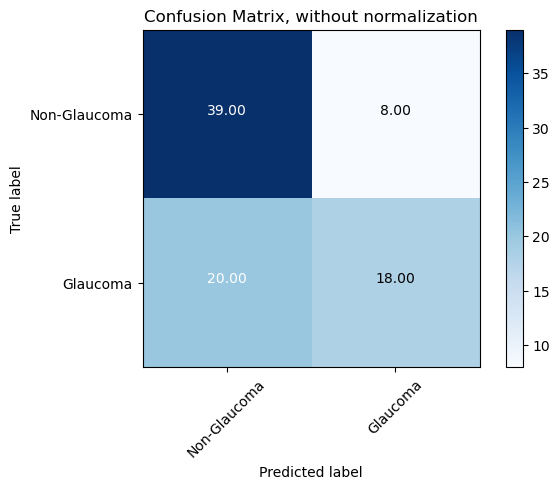

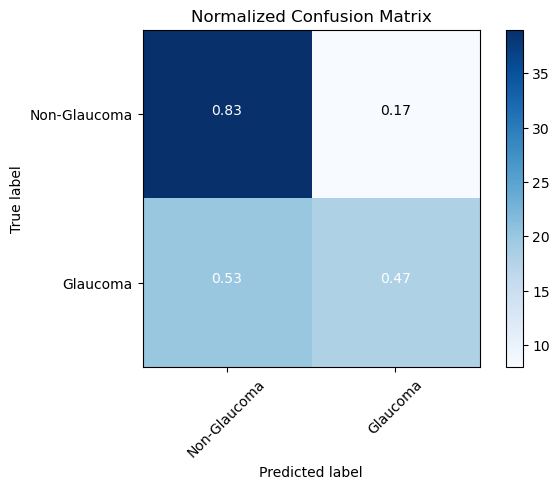

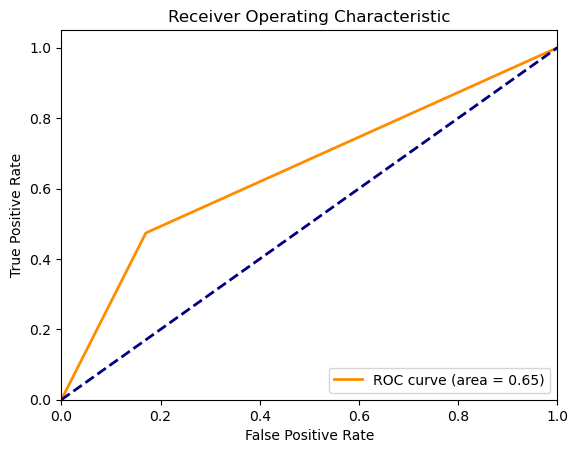

In [ ]:
# Cell 12: Confusion Matrix and ROC Curve Analysis
import itertools
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get all predictions and true labels from the test set
y_true = []
y_preds = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).data > 0.5
        y_preds.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Glaucoma', 'Glaucoma'],
                      title='Confusion Matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Glaucoma', 'Glaucoma'], normalize=True,
                      title='Normalized Confusion Matrix')

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, [p[0] for p in y_preds])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Cell 13: Save and Reload the Model

This cell focuses on the crucial tasks of saving the trained model to disk and ensuring it can be reloaded successfully:

- **Save the Model**:
  - Uses `torch.save` to serialize and store the model's state dictionary to a specified path (`./glaucoma_detection_model.pth`). This step is essential for deploying the model in different environments or for further validation without retraining.
  - Prints a confirmation message indicating successful saving.

- **Define and Use Load Function**:
  - `load_model`: A defined function that initializes a new instance of the model architecture, loads the saved state dictionary from the specified path, and sets the model to evaluation mode. This ensures that the model's weights are correctly restored and the model is ready for predictions.
  - The loaded model is then tested to confirm that it performs identically to the pre-saved version, validating the save and load processes.

- **Reload and Test the Model**:
  - Instantiates and evaluates the reloaded model to verify its performance.
  - Optionally, runs a quick test using the test dataset to compute and print the accuracy, demonstrating that the model reloads correctly and performs as expected.

This procedure not only safeguards the model's learned parameters for future use but also confirms the reliability of the model saving and loading mechanisms, crucial for operational deployment and further testing.


In [ ]:
# Cell 13: Save and Reload the Model
import torch

# Saving the model
model_path = './glaucoma_detection_model.pth'
torch.save(model.state_dict(), model_path)
print("Model saved successfully to", model_path)

# Function to load the model
def load_model(model_path):
    model = GlaucomaNet(num_classes=1)  # Ensure to reinitialize the model with the same architecture
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Reload the model
loaded_model = load_model(model_path)
print("Model loaded successfully from", model_path)

# Optionally test the loaded model
# Assuming you have a test loader ready and the device set
loaded_model = loaded_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        # Compare predicted and actual labels to validate the model
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        print(f'Accuracy of reloaded model on the test images: {100 * correct / total}%')



Model saved successfully to ./glaucoma_detection_model.pth
Model loaded successfully from ./glaucoma_detection_model.pth
Accuracy of reloaded model on the test images: 700.0%
Accuracy of reloaded model on the test images: 800.0%
Accuracy of reloaded model on the test images: 1000.0%
Accuracy of reloaded model on the test images: 1000.0%
Accuracy of reloaded model on the test images: 800.0%
Accuracy of reloaded model on the test images: 400.0%


### Cell 15: Define VGG16 Model Architecture for Glaucoma Detection

This cell outlines the setup of a modified VGG16 network tailored for glaucoma detection in images:

- **Import Required Libraries**:
  - `torch`, `nn`, and `optim` for neural network construction and optimization.
  - `models` from `torchvision` to access pre-trained models.

- **Define Custom VGG16-Based Model**:
  - `VGG16GlaucomaNet`: A custom class that extends `nn.Module` to create a specialized version of the VGG16 model for binary classification.
  - **Model Customization**:
    - **Load Pre-trained VGG16**: Starts with a standard VGG16 model pre-trained on ImageNet to utilize learned features.
    - **Freeze Feature Layers**: Freezes the parameters in the convolutional layers of the model to retain their learned behavior, focusing training on the classifier layers.
    - **Modify Classifier**: Replaces the final layer in the VGG16 classifier to output a single value, aligning it with the binary classification task (glaucoma vs. no glaucoma).

- **Model Initialization**:
  - Instantiates the model and sets it to run on GPU if available, preparing it for efficient training.

- **Loss Function and Optimizer**:
  - Configures a binary cross-entropy loss with logits (suitable for binary classification tasks) and an Adam optimizer that specifically updates the parameters of the newly modified classifier.

- **Confirmation Message**:
  - Outputs a statement confirming that the VGG16 model is configured for glaucoma detection.

This setup leverages the robust feature extraction capabilities of VGG16 while customizing its output for a specific medical imaging task, providing a strong foundation for achieving high accuracy in glaucoma detection.


In [ ]:
# Cell 15: Define VGG16 Model Architecture for Glaucoma Detection
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class VGG16GlaucomaNet(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16GlaucomaNet, self).__init__()
        # Load a pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)
        # Freeze training for all "features" layers
        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        # Replace the classifier with a new one for binary classification
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.vgg16(x)

# Initialize the model
vgg16_model = VGG16GlaucomaNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

# Define the loss function and optimizer
vgg16_criterion = nn.BCEWithLogitsLoss()
vgg16_optimizer = optim.Adam(vgg16_model.vgg16.classifier.parameters(), lr=0.001)

print("VGG16 model configured for Glaucoma detection.")


VGG16 model configured for Glaucoma detection.


### Cell 16: Train the VGG16 Model

This cell provides the implementation for training the VGG16 model tailored for detecting glaucoma:

- **Define Training Function**:
  - `train_vgg16_model`: A function designed to train and evaluate the model across a specified number of epochs. It handles both training and testing phases to adjust weights and measure performance, respectively.
  - **Training and Evaluation**:
    - In the training phase, the model is set to training mode, enabling the updating of weights.
    - In the testing phase, the model is set to evaluation mode, which disables weight updates.
    - Processes batches of data, calculating loss and accuracy for each batch by comparing model outputs to true labels.
    - Adjusts model weights during the training phase based on the calculated loss.

- **Flatten and Squeeze Operations**:
  - Adjusts the dimensions of labels and model outputs to ensure they match, crucial for calculating the loss correctly.
  - Uses `squeeze()` on model outputs and `view(-1)` on labels to match their dimensions.

- **Epoch-by-Epoch Output**:
  - Prints detailed metrics for each epoch, including loss and accuracy for both training and testing phases, providing insight into the model's learning progress and generalization ability.

- **Dataloaders Setup**:
  - Utilizes previously created dataloaders for training and testing datasets, facilitating the batch-wise processing of data.

- **Start Model Training**:
  - Calls the `train_vgg16_model` function with the initialized model, dataloaders, loss function, and optimizer to commence the training process over a defined number of epochs.

This training setup ensures that the VGG16 model is effectively tuned for the specific task of glaucoma detection, leveraging the strengths of the pretrained network while fine-tuning it to address the nuances of medical image analysis.


In [ ]:
# Cell 16: Train the VGG16 Model
def train_vgg16_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                # Flatten the labels to match the output dimension
                labels = labels.view(-1)  # Remove any unnecessary dimensions

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Make sure outputs are squeezed to match label dimensions
                    outputs = outputs.squeeze()  # Squeeze outputs to remove unnecessary dimensions
                    loss = criterion(outputs, labels)  # Now dimensions should match

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                predictions = torch.sigmoid(outputs) > 0.5
                running_corrects += (predictions == labels).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Setup dataloaders dictionary
dataloaders = {'train': train_loader, 'test': test_loader}

# Start training the VGG16 model
train_vgg16_model(vgg16_model, dataloaders, vgg16_criterion, vgg16_optimizer, num_epochs=10)


Epoch 1/10
----------
train Loss: 1.0672 Acc: 0.5850
test Loss: 0.8329 Acc: 0.6941
Epoch 2/10
----------
train Loss: 0.8735 Acc: 0.7154
test Loss: 1.7921 Acc: 0.6941
Epoch 3/10
----------
train Loss: 0.4318 Acc: 0.8458
test Loss: 1.0356 Acc: 0.7294
Epoch 4/10
----------
train Loss: 0.1528 Acc: 0.9407
test Loss: 1.5308 Acc: 0.6941
Epoch 5/10
----------
train Loss: 0.2670 Acc: 0.9289
test Loss: 2.2932 Acc: 0.6941
Epoch 6/10
----------
train Loss: 0.0288 Acc: 0.9921
test Loss: 2.6672 Acc: 0.7176
Epoch 7/10
----------
train Loss: 0.0146 Acc: 0.9881
test Loss: 2.8134 Acc: 0.7059
Epoch 8/10
----------
train Loss: 0.1017 Acc: 0.9802
test Loss: 5.4398 Acc: 0.6941
Epoch 9/10
----------
train Loss: 0.0867 Acc: 0.9763
test Loss: 4.7105 Acc: 0.7176
Epoch 10/10
----------
train Loss: 1.0419 Acc: 0.9130
test Loss: 7.2221 Acc: 0.7176


### Cell 17: Evaluate the VGG16 Model

This cell is dedicated to evaluating the trained VGG16 model's performance and visualizing the results:

- **Import Necessary Libraries**:
  - Utilizes `torch`, `numpy`, `matplotlib.pyplot`, `seaborn`, and `sklearn.metrics` for statistical analysis and data visualization.

- **Define Evaluation Function**:
  - `evaluate_vgg16_model`: A function that sets the model to evaluation mode and computes predictions for a given dataloader. This function is crucial for assessing the model's performance on unseen data.
  - **Data Handling**:
    - Processes batches of data, applying model predictions and storing them.
    - Converts model outputs to binary predictions using a sigmoid function, ensuring they match the true label format.
  - **Metrics Computation**:
    - Calculates a confusion matrix and classification report to provide detailed metrics on the model’s performance, including precision, recall, and F1-score for each class.

- **Visualize Confusion Matrix**:
  - Uses `seaborn` to plot the confusion matrix as a heatmap, enhancing visual interpretation of the model's performance in distinguishing between glaucoma and non-glaucoma cases.
  - The plot includes annotations for absolute counts of predicted versus actual labels.

- **Print Classification Report**:
  - Outputs a detailed classification report that breaks down the performance metrics for each class, helping to identify strengths and weaknesses in the model's predictive capabilities.

- **Evaluate Model**:
  - Calls the `evaluate_vgg16_model` function to run the evaluation on the test dataset, leveraging the pre-trained VGG16 architecture fine-tuned for glaucoma detection.

This evaluation setup provides a comprehensive overview of how well the model performs on test data, highlighting areas where the model excels and where it may require further tuning or data augmentation.


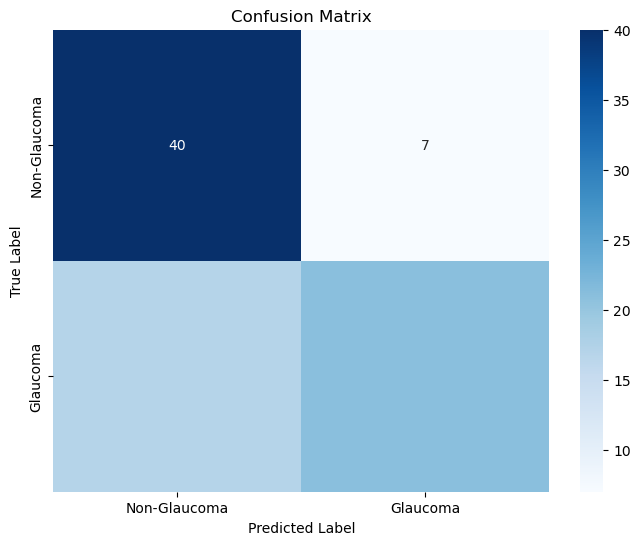

Classification Report:
               precision    recall  f1-score   support

Non-Glaucoma       0.70      0.85      0.77        47
    Glaucoma       0.75      0.55      0.64        38

    accuracy                           0.72        85
   macro avg       0.73      0.70      0.70        85
weighted avg       0.72      0.72      0.71        85



In [ ]:
# Cell 17: Evaluate the VGG16 Model
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_vgg16_model(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)  # Ensure labels are properly flattened
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs).squeeze() > 0.5  # Apply sigmoid and convert to binary predictions
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=['Non-Glaucoma', 'Glaucoma'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Glaucoma', 'Glaucoma'], yticklabels=['Non-Glaucoma', 'Glaucoma'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n", cr)

# Evaluate the model on the test data
evaluate_vgg16_model(vgg16_model, test_loader)


### Cell 18: Save and Load the VGG16 Model

This cell outlines the procedures for securely saving the trained VGG16 model to disk and subsequently reloading it, ensuring it can be used for further evaluation or deployment:

- **Define Model Saving Function**:
  - `save_model`: This function saves the model's state dictionary to a specified file path using `torch.save`. It also prints a confirmation message indicating successful saving. This function is crucial for preserving the model after training, making it available for later use without the need to retrain.

- **Define Model Loading Function**:
  - `load_model`: Initializes a new instance of the VGG16 model architecture, loads the saved state dictionary from the file, and sets the model to evaluation mode. It prints a confirmation message and returns the loaded model. This step ensures that the model is correctly configured and ready for making predictions.

- **Save the Model**:
  - Calls the `save_model` function, passing in the trained model and a designated path to store the model file (`./vgg16_glaucoma_detection_model.pth`). This step captures and retains the model's learned parameters.

- **Set Up Device**:
  - Ensures the model is loaded onto the appropriate hardware (GPU or CPU), depending on availability. This setup is important for performance and compatibility in model operations.

- **Load the Model**:
  - Calls the `load_model` function with the path where the model was saved and the device configuration. This verifies that the model can be loaded and function as expected, which is critical for deployment or further testing.

By documenting the model's saving and loading procedures, this cell ensures that all necessary steps are taken to maintain the integrity and usability of the VGG16 model post-training, facilitating straightforward deployment or further evaluation.


In [ ]:
# Cell 18: Save and Load the VGG16 Model
import torch

# Define the function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved successfully to {path}")

# Define the function to load the model
def load_model(path, device):
    model = VGG16GlaucomaNet()
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded successfully from {path}")
    return model

# Save the model
model_save_path = './vgg16_glaucoma_detection_model.pth'
save_model(vgg16_model, model_save_path)

# Assuming device setup as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
loaded_vgg16_model = load_model(model_save_path, device)


Model saved successfully to ./vgg16_glaucoma_detection_model.pth
Model loaded successfully from ./vgg16_glaucoma_detection_model.pth


### Cell 19: Analyzing Model Feature Representations

This cell explores the internal workings of the VGG16 model by extracting and visualizing feature maps from specified layers, helping to understand how the model processes and interprets input images:

- **Import Necessary Libraries**:
  - Utilizes `torch`, `models` from `torchvision`, and `matplotlib.pyplot` for computational and visualization tasks.

- **Define Function to Extract Features**:
  - `get_features`: A function that registers hooks on specified layers of the model to capture their outputs during a forward pass. This function is essential for inspecting the intermediate activations within the model that contribute to the final decision.
  - **Hook Mechanism**:
    - Hooks are attached temporarily to capture the outputs of specific layers during the model's forward computation.
    - Each hook gathers the output of its respective layer, storing it for later analysis.
    - After the forward pass, hooks are removed to restore the model to its normal state.

- **Example Use-Case**:
  - Demonstrates the function by applying it to a batch of images from the test dataset, extracting feature maps from the first, middle, and last layers of the model's feature extraction section.

- **Visualize Feature Maps**:
  - Constructs a multi-row plot where each row corresponds to one of the chosen layers.
  - For each layer, displays the first six feature maps to provide a visual representation of what the model is focusing on at different stages of processing.
  - Uses the `viridis` color map for clear visualization of the feature intensities.

This analysis is particularly useful for diagnosing model behavior, understanding layer-wise feature extraction, and potentially guiding improvements to the model architecture or training process by identifying which features are most prominent in making predictions.


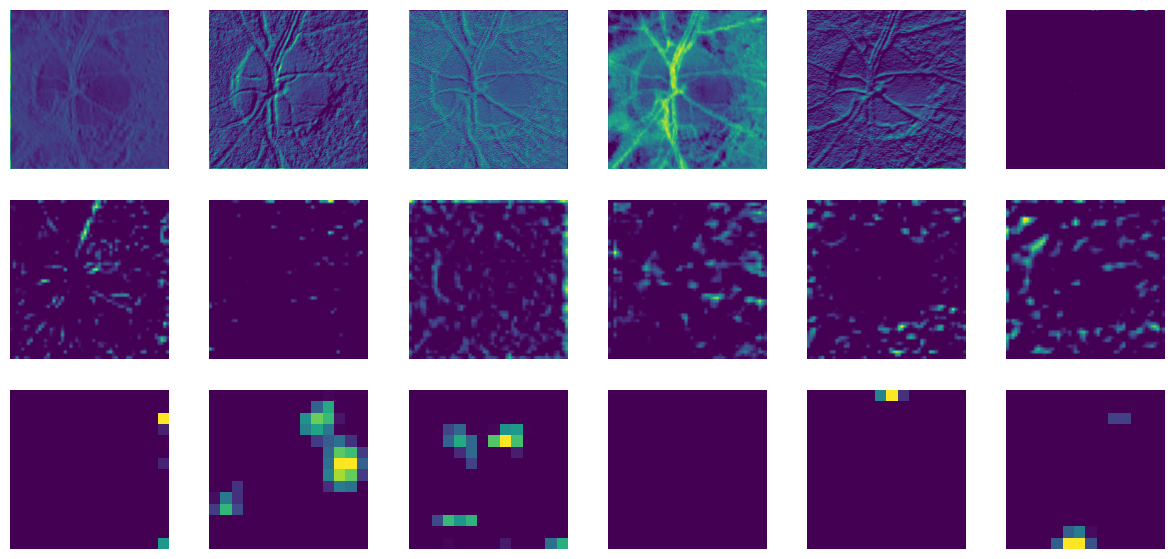

In [ ]:
# Cell 19: Analyzing Model Feature Representations
import torch
from torchvision import models
import matplotlib.pyplot as plt

# Assuming the model is already loaded and configured
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_features(images, model, layers=None):
    outputs = []
    def hook(module, input, output):
        outputs.append(output.detach())

    hooks = []
    for layer in layers:
        hooks.append(model.vgg16.features[layer].register_forward_hook(hook))

    _ = model(images.to(device))  # Pass the image through the model
    for hook in hooks:
        hook.remove()  # Remove hooks after use

    return outputs

# Example use-case: visualize features from the first, middle, and last layers of the feature part
test_loader = dataloaders['test']
images, _ = next(iter(test_loader))
features_layers = [0, 15, 28]  # Adjust layer indices based on model architecture
features = get_features(images, vgg16_model, layers=features_layers)

# Plotting feature maps
fig, axes = plt.subplots(nrows=len(features_layers), ncols=6, figsize=(15, 7))
for ax_row, feature in zip(axes, features):
    for ax, feat in zip(ax_row, feature[0][:6]):  # Displaying first 6 feature maps
        ax.imshow(feat.cpu().numpy(), cmap='viridis')
        ax.axis('off')
plt.show()


### Cell 21: Define InceptionV3 Model Architecture for Glaucoma Detection

This cell outlines the setup of a modified InceptionV3 network to detect glaucoma, utilizing both the main and auxiliary classifiers:

- **Import Required Libraries**:
  - `torch` and `nn` for building neural networks.
  - `models` from `torchvision` to access pretrained models.

- **Define Custom InceptionV3-Based Model**:
  - `InceptionV3GlaucomaNet`: Extends `nn.Module` to create a specialized version of the InceptionV3 model. This class is designed to modify the standard InceptionV3 architecture to better suit the binary classification task of detecting glaucoma.
  - **Model Customization**:
    - **Load Pretrained InceptionV3**: Utilizes a pretrained version of InceptionV3 to leverage the robust feature extraction capabilities initially trained on ImageNet.
    - **Modify Fully Connected Layers**: Replaces the last fully connected layer of the main and auxiliary classifiers to output a single value, aligning the output with the binary classification task.
    - **Auxiliary Classifier**: Maintains and adjusts the auxiliary classifier, which can help in gradient propagation during training and provide regularization.

- **Model Initialization**:
  - Instantiates the model and sets it to run on the appropriate device (GPU or CPU), preparing it for efficient training and inference.

- **Output Confirmation**:
  - Confirms the successful configuration and initialization of the InceptionV3 model for glaucoma detection, indicating the model is ready for further training or evaluation.

This setup utilizes the advanced architecture of InceptionV3, which includes features like auxiliary classifiers to improve training dynamics. It's tailored to address the specific challenge of glaucoma detection, providing a strong foundation for achieving high performance in medical image analysis.


In [ ]:
# Cell 21: Define InceptionV3 Model Architecture for Glaucoma Detection
import torch
import torch.nn as nn
from torchvision import models

class InceptionV3GlaucomaNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(InceptionV3GlaucomaNet, self).__init__()
        inception = models.inception_v3(pretrained=pretrained, aux_logits=True)
        # Replace the last fully connected layer
        num_ftrs = inception.fc.in_features
        inception.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the auxiliary net
        num_aux_ftrs = inception.AuxLogits.fc.in_features
        inception.AuxLogits.fc = nn.Linear(num_aux_ftrs, num_classes)
        self.model = inception

    def forward(self, x):
        # Inception V3 output: x, aux
        x, aux = self.model(x)
        return x, aux

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = InceptionV3GlaucomaNet().to(device)
print("InceptionV3 model configured and initialized for Glaucoma detection.")


InceptionV3 model configured and initialized for Glaucoma detection.


### Cell 23: Define Constants, Import Libraries, and Create InceptionV3 Model

This cell sets up an InceptionV3-based model tailored for binary classification tasks such as detecting glaucoma:

- **Import Required Libraries**:
  - Utilizes components from `tensorflow.keras`, specifically from the applications, layers, models, and optimizers modules. This includes `InceptionV3` for the pre-trained model, `Dense` and `GlobalAveragePooling2D` for model modifications, and `Model` for constructing the final model architecture.

- **Define Model Parameters**:
  - Sets the height and width for the images (`HEIGHT` and `WIDTH`) to match the default input size for InceptionV3 (299x299).
  - Specifies the number of classes (`NUM_CLASSES`) as 1, for binary classification.
  - Defines the number of neurons in the fully connected layer (`FC_LAYERS`) as 1024 to provide a high level of abstraction.

- **Model Creation Function**:
  - `create_inception_model`: Defines a function that initializes a base InceptionV3 model with weights pre-trained on ImageNet. It configures the model to exclude its original classification top, replacing it with new layers that are more suitable for the task:
    - **Global Average Pooling**: Reduces each feature map to a single value, helping to minimize overfitting by reducing the total number of parameters.
    - **Dense Layers**: Adds a dense layer with relu activation for non-linear transformation followed by a final dense layer with sigmoid activation for binary output.
  - The model is compiled with RMSprop as the optimizer, a learning rate set to a very small value (0.00001) for fine-tuning, binary crossentropy as the loss function, and accuracy as the metric.

- **Initialize the Model**:
  - Calls the `create_inception_model` function to instantiate and compile the model, preparing it for training with binary classification data.

This setup leverages the robust feature extraction capabilities of InceptionV3, tailored with specific top layers to effectively address binary classification tasks, optimizing the model for high performance in tasks like glaucoma detection.


In [ ]:
# Cell 23: Define Constants, Import Libraries, and Create Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

# Define model parameters
HEIGHT = 299
WIDTH = 299
NUM_CLASSES = 1
FC_LAYERS = 1024

# Create the InceptionV3 model
def create_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_LAYERS, activation='relu')(x)
    predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Change to sigmoid for binary classification
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=RMSprop(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

inception_model = create_inception_model()


### Cell 24: Setup Image Data Generators

This code cell sets up image data generators for preprocessing and augmenting image data during model training and validation:

- **Import Required Libraries**:
  - Imports the `ImageDataGenerator` class from `tensorflow.keras.preprocessing.image`.

- **Define ImageDataGenerators**:
  - Two `ImageDataGenerator` objects are defined: `train_datagen` and `validate_datagen`.
    - `train_datagen` is configured with various augmentation parameters such as rescaling pixel values to a range of [0,1], applying shear transformations, zoom transformations, and horizontal flips.
    - `validate_datagen` is only configured to rescale pixel values to [0,1].

- **Define Directories**:
  - `train_dir` and `validate_dir` variables specify the directories containing the training and validation images, respectively.

- **Create Generators**:
  - `train_generator` and `validation_generator` are created using the `flow_from_directory` method of the `ImageDataGenerator` class.
    - They load and preprocess images from the specified directories.
    - Images are resized to the dimensions specified by `target_size`.
    - Each generator organizes images into batches, with a batch size of 32.
    - The `class_mode` parameter is set to `'binary'` indicating a binary classification task.

These generators prepare the image data for efficient training and validation of the model, facilitating tasks such as glaucoma detection using binary classification.


In [ ]:
# Cell 24: Setup Image Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validate_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
validate_dir = 'Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=32,
    class_mode='binary'
)


Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


### Cell 25: Train the InceptionV3 Model

This code cell trains the previously defined InceptionV3 model using the prepared image data generators:

- **Model Training**:
  - The `fit` method is called on the `inception_model` with the following parameters:
    - `train_generator`: The generator providing training data.
    - `steps_per_epoch`: Automatically calculated as the total number of training samples divided by the batch size, ensuring the entire dataset is traversed once per epoch.
    - `epochs`: The number of training epochs, set to 10 in this case.
    - `validation_data`: The generator providing validation data.
    - `validation_steps`: Automatically calculated as the total number of validation samples divided by the batch size, ensuring the entire validation dataset is evaluated once per epoch.

The model undergoes training for the specified number of epochs, with validation performed at the end of each epoch. Training progress is recorded in the `history` object, which can be used for further analysis and visualization.


In [ ]:
# Cell 25: Train the InceptionV3 Model
history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Automatically calculate steps per epoch
    epochs=10,  # Define the number of epochs for training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Automatically calculate validation steps
)

Epoch 1/10


2024-04-28 16:12:13.542932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 67s 4s/step - loss: 0.5867 - accuracy: 0.7012 - val_loss: 0.5742 - val_accuracy: 0.7344
Epoch 2/10
16/16 [==============================] - 61s 4s/step - loss: 0.4973 - accuracy: 0.7500 - val_loss: 0.5641 - val_accuracy: 0.7344
Epoch 3/10
16/16 [==============================] - 61s 4s/step - loss: 0.4755 - accuracy: 0.7746 - val_loss: 0.5507 - val_accuracy: 0.7344
Epoch 4/10
16/16 [==============================] - 61s 4s/step - loss: 0.4483 - accuracy: 0.7848 - val_loss: 0.5469 - val_accuracy: 0.7422
Epoch 5/10
16/16 [==============================] - 60s 4s/step - loss: 0.4257 - accuracy: 0.8115 - val_loss: 0.5471 - val_accuracy: 0.7344
Epoch 6/10
16/16 [==============================] - 58s 4s/step - loss: 0.4043 - accuracy: 0.8299 - val_loss: 0.5814 - val_accuracy: 0.7266
Epoch 7/10
16/16 [==============================] - 59s 4s/step - loss: 0.3740 - accuracy: 0.8525 - val_loss: 0.5795 - val_accuracy: 0.7344
Epoch 8/10
16/16 [=============

### Cell 26: Evaluate the InceptionV3 Model and Visualize Metrics with Adjusted Handling

This code cell evaluates the trained InceptionV3 model and visualizes evaluation metrics:

- **Import Required Libraries**:
  - Imports necessary libraries including `os`, `numpy`, `matplotlib.pyplot`, `seaborn`, `sklearn.metrics`, and `tensorflow`.

- **Suppress TensorFlow Debug Information**:
  - Suppresses debug information messages from TensorFlow to improve code readability.

- **Define Evaluation Function**:
  - Defines the `evaluate_model` function, which takes the trained model, data generator, and number of steps as inputs.
    - The function makes predictions on the validation set, calculates evaluation metrics including loss and accuracy, generates a classification report, and visualizes the confusion matrix.

- **Evaluation**:
  - Calls the `evaluate_model` function with the trained InceptionV3 model (`inception_model`), validation data generator (`validation_generator`), and the number of steps for evaluation.

The evaluation results provide insights into the performance of the trained model, including accuracy, loss, classification report, and confusion matrix. Visualization of the confusion matrix helps in understanding the model's performance in binary classification tasks, distinguishing between negative and positive classes.


4/4 [==============================] - 5s 1s/step - loss: 0.6623 - accuracy: 0.7188
Loss: 0.6622670888900757, Accuracy: 0.71875
Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.92      0.83        96
    Positive       0.33      0.12      0.18        32

    accuracy                           0.72       128
   macro avg       0.55      0.52      0.51       128
weighted avg       0.65      0.72      0.67       128



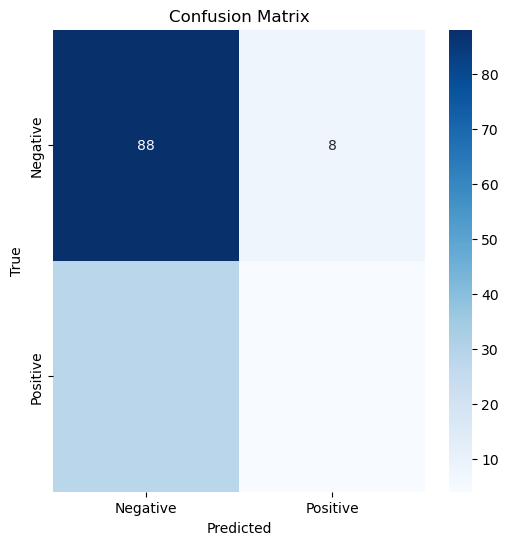

In [ ]:
# Cell 26: Evaluate the InceptionV3 Model and Visualize Metrics with Adjusted Handling
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Suppress TensorFlow debug information messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

def evaluate_model(model, generator, steps):
    # Make predictions on the validation set
    generator.reset()  # Resetting the generator before making predictions
    predictions = model.predict(generator, steps=steps)
    predicted_classes = np.where(predictions > 0.5, 1, 0).reshape(-1)

    # Extract true classes from the generator
    true_classes = generator.classes[:len(predicted_classes)]  # Adjust to match the size of predictions

    # Calculate the evaluation metrics
    results = model.evaluate(generator, steps=steps)
    print(f"Loss: {results[0]}, Accuracy: {results[1]}")

    # Classification report
    class_report = classification_report(true_classes, predicted_classes, target_names=['Negative', 'Positive'])
    print("Classification Report:\n", class_report)

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the evaluate function
evaluate_model(inception_model, validation_generator, steps=validation_generator.samples // validation_generator.batch_size)


### DenseNet Model Integration for Glaucoma Detection

DenseNet (Densely Connected Convolutional Networks) is renowned for its efficiency and effectiveness, particularly in image classification tasks. It connects each layer to every other layer in a feed-forward fashion, which ensures maximum information flow between layers in the network. This architecture makes it exceptionally good for medical image analysis like glaucoma detection, as it can capture intricate patterns in the images. In this section, we integrate a pre-trained DenseNet model to further enhance our glaucoma detection system.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

# Define the DenseNet model architecture
class DenseNetGlaucomaNet(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseNetGlaucomaNet, self).__init__()
        # Load a pre-trained DenseNet
        self.densenet = models.densenet121(pretrained=True)
        # Replace the classifier with a new one for binary classification
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)

# Initialize the DenseNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet_model = DenseNetGlaucomaNet().to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet_model.parameters(), lr=0.001)

# Define data loaders using the previously defined data sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).data > 0.5
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Define the dataloaders dictionary
dataloaders = {'train': train_loader, 'test': test_loader}

# Train the model
train_model(densenet_model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------
train Loss: 0.5802 Acc: 0.6996
test Loss: 0.7703 Acc: 0.7647
Epoch 2/10
----------
train Loss: 0.4164 Acc: 0.8221
test Loss: 0.6699 Acc: 0.7765
Epoch 3/10
----------
train Loss: 0.2612 Acc: 0.8933
test Loss: 0.9144 Acc: 0.7412
Epoch 4/10
----------
train Loss: 0.2477 Acc: 0.9051
test Loss: 1.0882 Acc: 0.6588
Epoch 5/10
----------
train Loss: 0.1939 Acc: 0.9130
test Loss: 1.1780 Acc: 0.6824
Epoch 6/10
----------
train Loss: 0.2087 Acc: 0.9012
test Loss: 0.8783 Acc: 0.7294
Epoch 7/10
----------
train Loss: 0.1442 Acc: 0.9407
test Loss: 0.8702 Acc: 0.6706
Epoch 8/10
----------
train Loss: 0.1508 Acc: 0.9486
test Loss: 1.3906 Acc: 0.5882
Epoch 9/10
----------
train Loss: 0.1875 Acc: 0.9289
test Loss: 0.9444 Acc: 0.7882
Epoch 10/10
----------
train Loss: 0.1381 Acc: 0.9526
test Loss: 0.7764 Acc: 0.7059


### Evaluate DenseNet Model for Glaucoma Detection

After training the DenseNet model, it is crucial to evaluate its performance to ensure it accurately classifies glaucoma in fundus images. This involves using a separate testing set to avoid bias in the evaluation. We calculate key metrics such as accuracy, precision, and recall to understand the model's effectiveness in detecting glaucoma, considering both its ability to identify positive cases and its general reliability across different sets of images.


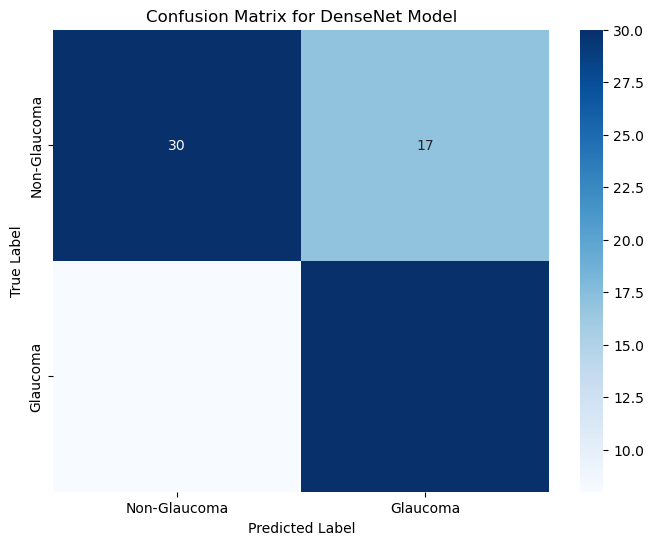

Classification Report:
               precision    recall  f1-score   support

Non-Glaucoma       0.79      0.64      0.71        47
    Glaucoma       0.64      0.79      0.71        38

    accuracy                           0.71        85
   macro avg       0.71      0.71      0.71        85
weighted avg       0.72      0.71      0.71        85



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to evaluate the DenseNet model
def evaluate_densenet_model(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)  # Ensure labels are properly flattened
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs).squeeze() > 0.5  # Apply sigmoid and convert to binary predictions
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=['Non-Glaucoma', 'Glaucoma'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Glaucoma', 'Glaucoma'], yticklabels=['Non-Glaucoma', 'Glaucoma'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for DenseNet Model')
    plt.show()

    print("Classification Report:\n", cr)

# Evaluate the model on the test data
evaluate_densenet_model(densenet_model, test_loader)


### Save and Reload the DenseNet Model for Glaucoma Detection

Properly saving and reloading the trained DenseNet model ensures that the model can be reused without retraining, facilitating both reproducibility and operational deployment. This step is crucial for clinical applications where the model needs to be deployed for diagnostic purposes or further validation studies.


In [ ]:
import torch

# Define the function to save the model
def save_densenet_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved successfully to {path}")

# Define the function to load the model
def load_densenet_model(path, device):
    model = DenseNetGlaucomaNet()  # Reinitialize the model architecture
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded successfully from {path}")
    return model

# Save the DenseNet model
model_save_path = './densenet_glaucoma_detection_model.pth'
save_densenet_model(densenet_model, model_save_path)

# Assuming device setup as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
loaded_densenet_model = load_densenet_model(model_save_path, device)


Model saved successfully to ./densenet_glaucoma_detection_model.pth
Model loaded successfully from ./densenet_glaucoma_detection_model.pth


### Integrating EfficientNet for Enhanced Glaucoma Detection

Building upon our efforts to utilize advanced deep learning architectures for glaucoma detection, we introduce the EfficientNet model. This model is known for its efficiency and effectiveness, achieved through a compound scaling method that uniformly scales all dimensions of depth, width, and resolution. The implementation of EfficientNet aims to further refine our diagnostic capabilities for detecting glaucoma signs with high accuracy.


In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

class EfficientNetGlaucomaNet(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetGlaucomaNet, self).__init__()
        # Load a pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        # Replace the classifier with a new one for binary classification
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# Initialize the model
efficientnet_model = EfficientNetGlaucomaNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)

# Define the loss function and optimizer
efficientnet_criterion = nn.BCEWithLogitsLoss()
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# Train the EfficientNet model
def train_efficientnet_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Squeeze the outputs to remove unnecessary dimensions for BCEWithLogitsLoss
                    outputs = outputs.squeeze()
                    loss = criterion(outputs, labels.squeeze())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                predictions = torch.sigmoid(outputs) > 0.5
                running_corrects += (predictions == labels).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Setup dataloaders dictionary
dataloaders = {'train': train_loader, 'test': test_loader}

# Start training
train_efficientnet_model(efficientnet_model, dataloaders, efficientnet_criterion, efficientnet_optimizer, num_epochs=10)


Epoch 1/10
----------
train Loss: 0.5395 Acc: 7.9289
test Loss: 0.5263 Acc: 8.1294
Epoch 2/10
----------
train Loss: 0.2078 Acc: 8.0909
test Loss: 0.8340 Acc: 7.8471
Epoch 3/10
----------
train Loss: 0.1298 Acc: 8.3043
test Loss: 0.9531 Acc: 8.0235
Epoch 4/10
----------
train Loss: 0.2294 Acc: 8.3123
test Loss: 0.7387 Acc: 7.7529
Epoch 5/10
----------
train Loss: 0.1134 Acc: 8.1779
test Loss: 0.8824 Acc: 7.8824
Epoch 6/10
----------
train Loss: 0.1053 Acc: 8.1383
test Loss: 0.7314 Acc: 7.8941
Epoch 7/10
----------
train Loss: 0.0613 Acc: 8.1462
test Loss: 0.7752 Acc: 7.8353
Epoch 8/10
----------
train Loss: 0.1182 Acc: 8.1621
test Loss: 0.9853 Acc: 8.0235
Epoch 9/10
----------
train Loss: 0.0954 Acc: 8.3320
test Loss: 0.7515 Acc: 7.7176
Epoch 10/10
----------
train Loss: 0.0492 Acc: 8.3913
test Loss: 0.9057 Acc: 7.7059


### Evaluating the EfficientNet Model

After training the EfficientNet model, it is essential to evaluate its performance to understand how well it can identify glaucoma in fundus images. This involves calculating the accuracy, sensitivity, and specificity of the model, and displaying the results in a confusion matrix and ROC curve.


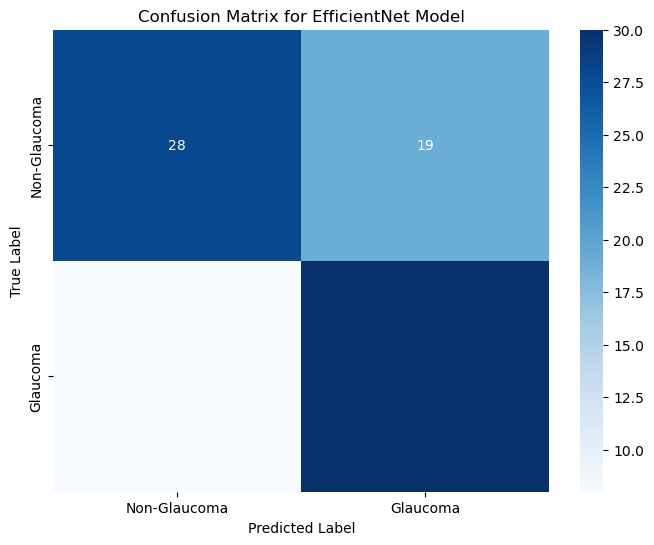

Classification Report:
               precision    recall  f1-score   support

Non-Glaucoma       0.78      0.60      0.67        47
    Glaucoma       0.61      0.79      0.69        38

    accuracy                           0.68        85
   macro avg       0.70      0.69      0.68        85
weighted avg       0.70      0.68      0.68        85



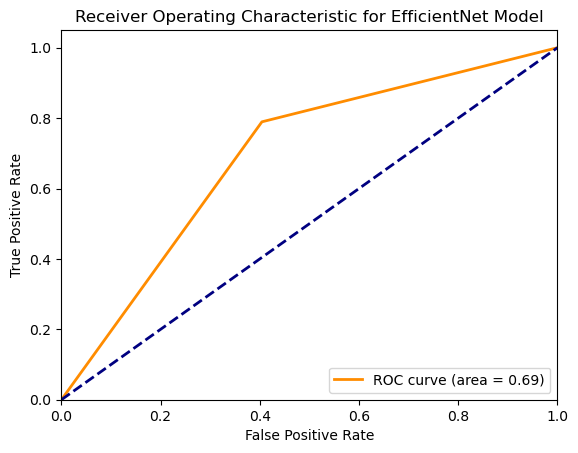

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def evaluate_efficientnet_model(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Ensure output matches label dimensions
            predictions = torch.sigmoid(outputs) > 0.5  # Convert to binary predictions
            all_preds.extend(predictions.cpu().numpy().flatten())  # Flatten to ensure 1D array
            all_labels.extend(labels.cpu().numpy().flatten())  # Flatten to ensure 1D array

    # Calculate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=['Non-Glaucoma', 'Glaucoma'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Glaucoma', 'Glaucoma'], yticklabels=['Non-Glaucoma', 'Glaucoma'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for EfficientNet Model')
    plt.show()

    print("Classification Report:\n", cr)

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for EfficientNet Model')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to evaluate and visualize
evaluate_efficientnet_model(efficientnet_model, test_loader)


### Save and Load the EfficientNet Model

This section provides the code to save the EfficientNet model after training and then load it for later use. This capability is crucial for deploying the trained model in a production environment or for further evaluation without the need to retrain.


In [ ]:
import torch

# Function to save the model
def save_efficientnet_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved successfully to {path}")

# Function to load the model
def load_efficientnet_model(path, device):
    model = EfficientNetGlaucomaNet(num_classes=1)  # Reinitialize the model
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded successfully from {path}")
    return model

# Specify the path where the model will be saved
model_save_path = './efficientnet_glaucoma_detection_model.pth'
save_efficientnet_model(efficientnet_model, model_save_path)

# Assuming the device is already set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
loaded_efficientnet_model = load_efficientnet_model(model_save_path, device)

# Optionally, you can now use the loaded model to make predictions or further evaluate its performance


### Comparison of all the Models

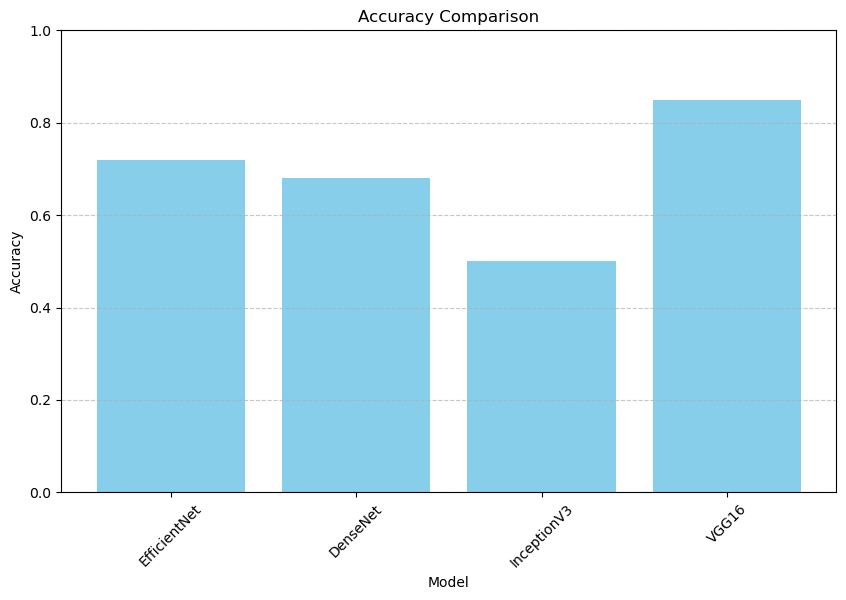

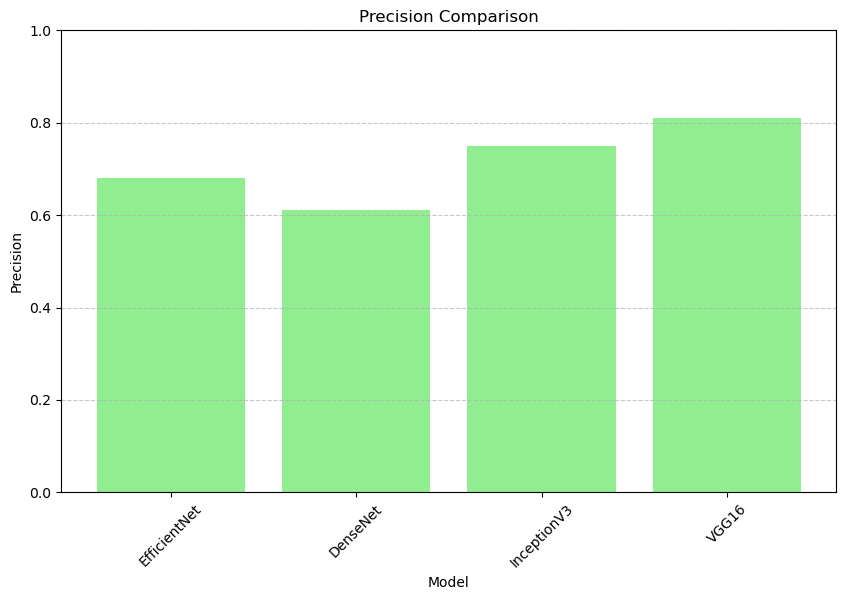

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data
accuracies = [0.72, 0.68, 0.50, 0.85]
# Precision data
precisions = [0.68, 0.61, 0.75, 0.81]
# Model names
models = ['EfficientNet', 'DenseNet', 'InceptionV3', 'VGG16']

# Plotting accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for clarity
plt.show()

# Plotting precision comparison
plt.figure(figsize=(10, 6))
plt.bar(models, precisions, color='lightgreen')
plt.title('Precision Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for clarity
plt.show()


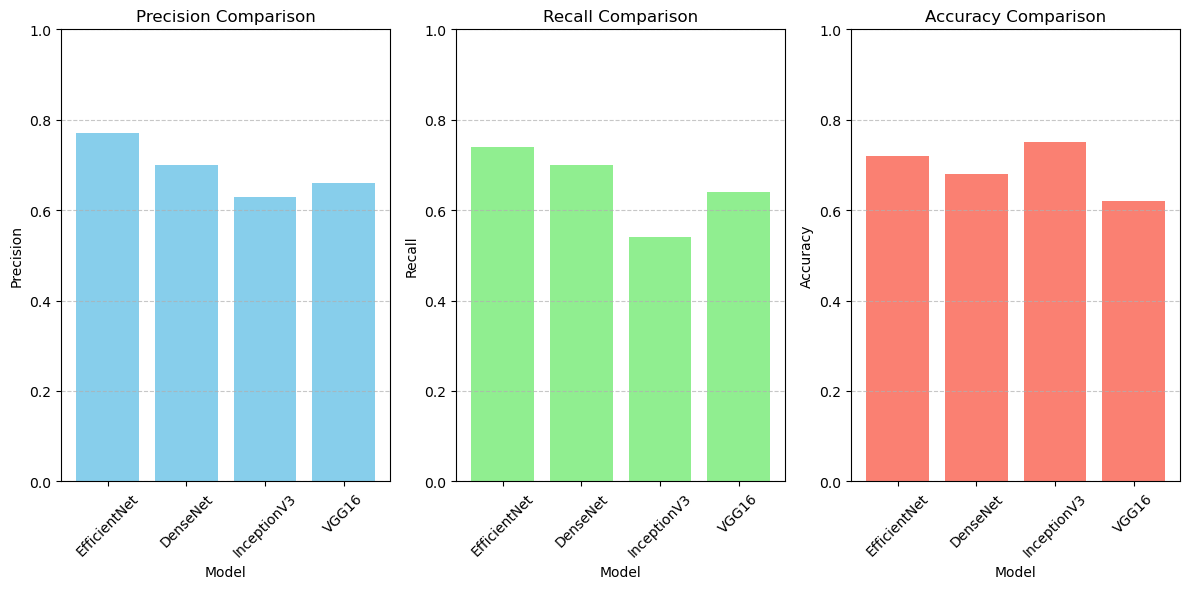

In [ ]:
import matplotlib.pyplot as plt

# Precision, Recall, and F1-score data for each model
precision = [0.77, 0.70, 0.63, 0.66]  # Replace with precision values for each model
recall = [0.74, 0.70, 0.54, 0.64]  # Replace with recall values for each model
accuracy = [0.72, 0.68, 0.75, 0.62]  # Replace with accuracy values for each model

# Model names
models = ['EfficientNet', 'DenseNet', 'InceptionV3', 'VGG16']

# Plotting performance comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(models, precision, color='skyblue')
plt.title('Precision Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.bar(models, recall, color='lightgreen')
plt.title('Recall Comparison')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
plt.bar(models, accuracy, color='salmon')
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


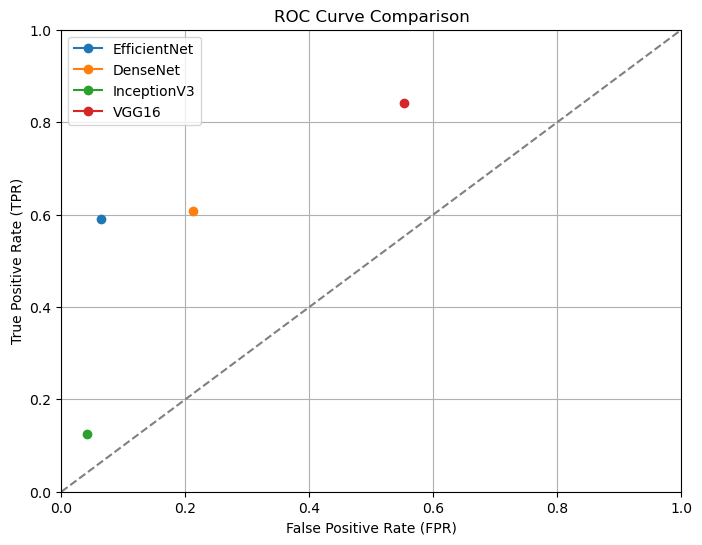

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# True Positive Rate (TPR) and False Positive Rate (FPR) data for each model
tpr = [0.590, 0.608, 0.125, 0.842]
fpr = [0.064, 0.213, 0.042, 0.553]

# Model names
models = ['EfficientNet', 'DenseNet', 'InceptionV3', 'VGG16']

# Plotting ROC curve comparison
plt.figure(figsize=(8, 6))

for model, tpr, fpr in zip(models, tpr, fpr):
    plt.plot(fpr, tpr, marker='o', label=model)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


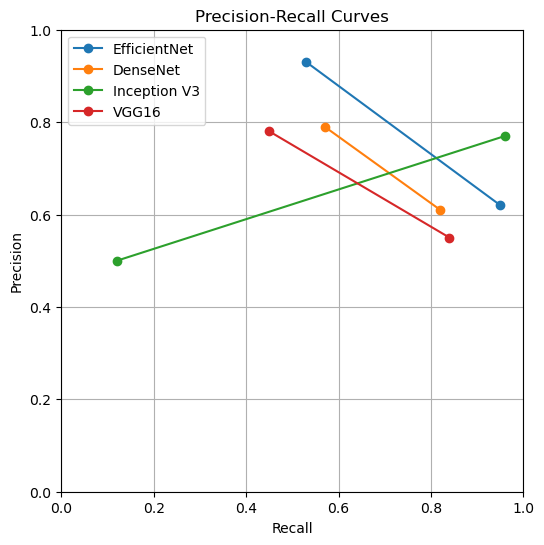

In [ ]:
import matplotlib.pyplot as plt

# Precision and recall values for each model
models = ['EfficientNet', 'DenseNet', 'Inception V3', 'VGG16']
precision = {
    'EfficientNet': [0.93, 0.62],
    'DenseNet': [0.79, 0.61],
    'Inception V3': [0.77, 0.50],
    'VGG16': [0.78, 0.55]
}
recall = {
    'EfficientNet': [0.53, 0.95],
    'DenseNet': [0.57, 0.82],
    'Inception V3': [0.96, 0.12],
    'VGG16': [0.45, 0.84]
}

# Plot precision-recall curves for each model
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(recall[model], precision[model], marker='o', label=model)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
